# 21.3 Risk Parity & Factor-Based Portfolio Construction
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

Introduces tail-risk–aware portfolio optimization through the Conditional Value at Risk (CVaR), also known as Expected Shortfall (ES).

Unlike variance-based methods, which treat upside and downside symmetrically, CVaR focuses explicitly on extreme losses and has become a standard risk measure in institutional finance. Obejectives are : 

- move beyond variance as a risk measure,
- explicitly model extreme losses using historical scenarios,
- formulate and solve a convex CVaR optimization problem,
- compare CVaR-optimal portfolios to Mean–Variance and Risk Parity allocations,
- analyze how tail-risk constraints reshape portfolio weights and drawdowns.

**This notebook**: 

Reflects modern risk management practices, where CVaR/ES has largely replaced variance-based measures.

# 0. Imports

- Variance is known to underestimate tail risk, especially for financial returns exhibiting skewness and fat tails.
 
- Value at Risk (VaR) improves on variance by focusing on quantiles of the loss distribution, but it remains non-coherent (it fails subadditivity).

- CVaR, defined as the expected loss beyond the VaR threshold, is a coherent risk measure and directly targets tail behavior.

We work with daily data, where tail effects are more visible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

np.random.seed(42)

In [2]:
tickers = ["SPY", "QQQ", "TLT", "GLD", "EFA", "EEM", "HYG"]
start_date = "2010-01-01"

prices = yf.download(tickers, start=start_date, progress=False)["Close"]
prices = prices.dropna()

returns_d = np.log(prices / prices.shift(1)).dropna()
returns_d.head()

Ticker,EEM,EFA,GLD,HYG,QQQ,SPY,TLT
Date,,,,,,,
2010-01-05,0.007232,0.000881,-0.000911,0.004734,0.000000,0.002644,0.006437
2010-01-06,0.002090,0.004218,0.016365,0.002582,-0.006051,0.000704,-0.013476
2010-01-07,-0.005816,-0.003866,-0.006207,0.004029,0.000650,0.004212,0.001680
2010-01-08,0.007902,0.007891,0.004951,0.001563,0.008197,0.003323,-0.000447
2010-01-11,-0.002086,0.008176,0.013201,-0.000893,-0.004090,0.001395,-0.005503


**Exploratory plots**

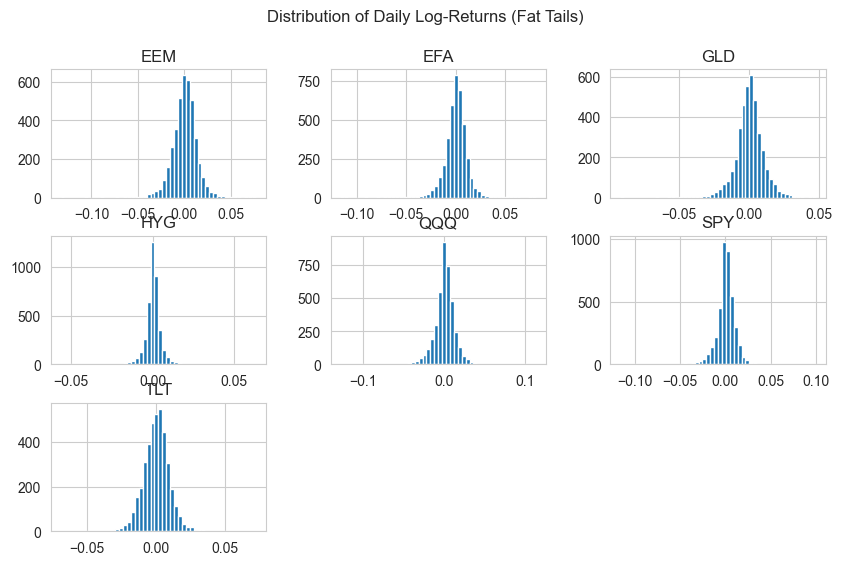

In [3]:
returns_d.hist(bins=50, figsize=(10, 6))
plt.suptitle("Distribution of Daily Log-Returns (Fat Tails)")
plt.show()

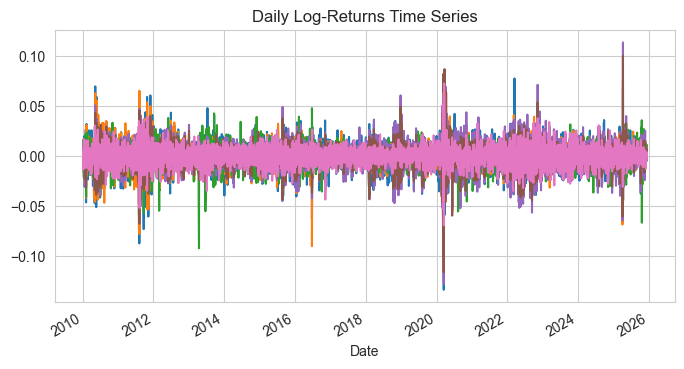

In [4]:
returns_d.plot(legend=False, title="Daily Log-Returns Time Series")
plt.show()

Across all assets, daily log-returns display pronounced excess kurtosis and asymmetric tails, with extreme negative moves occurring far more often than a Gaussian benchmark would imply.
These tail events cluster in time (e.g. crisis periods), making variance alone an insufficient risk descriptor.
This directly justifies tail-aware frameworks (VaR / CVaR, drawdown constraints, regime-dependent risk models) rather than mean–variance assumptions.

# 1. CVaR Formulation

Let portfolio loss be defined as:
$$
L = -\mathbf{w}^\top \mathbf{R}
$$

For a confidence level $\alpha$, CVaR is defined as:
$$
\operatorname{CVaR}_\alpha(L)
= \min_{\eta}\left\{
\eta + \frac{1}{1-\alpha}\,\mathbb{E}\big[(L-\eta)^{+}\big]
\right\}
$$

where:
- $\eta$ approximates the VaR at level $\alpha$,
- $(x)^{+} = \max(x, 0)$,
- the objective is convex in $(\mathbf{w}, \eta)$.

This formulation is particularly suitable for scenario-based optimization.

# 2. Scenario-Based Setup

We treat historical returns as scenarios.

Let:
$$
\mathbf{R} \in \mathbb{R}^{T \times N} \quad\text{(matrix of asset returns)},\qquad
\mathbf{w} \in \mathbb{R}^{N} \quad\text{(portfolio weights)}
$$

Portfolio losses across scenarios are:
$$
L_t = -\mathbf{R}_t\,\mathbf{w}
$$

We set a confidence level $\alpha = 95\%$.


In [5]:
R = returns_d.values
T, N = R.shape

alpha = 0.95

# 3. CVaR Optimization Problem

We introduce auxiliary variables \( z_t \ge 0 \) to linearize the positive part.

The optimization problem becomes:

$$
\begin{aligned}
\min_{w,\eta,z}\quad & \eta + \frac{1}{(1-\alpha)T}\sum_{t=1}^T z_t \\
\text{s.t.}\quad & z_t \ge 0,\quad \forall t,\\
& z_t \ge L_t - \eta,\quad \forall t,\\
& \sum_{i=1}^N w_i = 1,\\
& w_i \ge 0,\quad \forall i.
\end{aligned}
$$

This is a convex linear program.


In [6]:
w = cp.Variable(N)
eta = cp.Variable()
z = cp.Variable(T)

losses = -R @ w

objective = cp.Minimize(
    eta + (1 / ((1 - alpha) * T)) * cp.sum(z)
)

constraints = [
    z >= 0,
    z >= losses - eta,
    cp.sum(w) == 1,
    w >= 0
]

problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(0.010019321231400043)

In [8]:
w_cvar = pd.Series(w.value, index=returns_d.columns)
w_cvar

Ticker
EEM    6.653354e-14
EFA    5.418547e-13
GLD    1.120701e-01
HYG    6.683977e-01
QQQ    3.399334e-13
SPY    8.759231e-13
TLT    2.195322e-01
dtype: float64

# 4. Benchmark Portfolios

We compare the CVaR-optimal portfolio to:
- Mean–Variance (from NB01),
- Risk Parity (ERC) (from NB02).

For simplicity and consistency, we recompute them here.

In [9]:
# Mean–Variance (minimum variance, daily)
Sigma_d = returns_d.cov().values
mu_dummy = np.zeros(N)

w_mv = cp.Variable(N)
prob_mv = cp.Problem(
    cp.Minimize(cp.quad_form(w_mv, Sigma_d)),
    [cp.sum(w_mv) == 1, w_mv >= 0]
)
prob_mv.solve()
w_mv = pd.Series(w_mv.value, index=returns_d.columns)

In [10]:
# Mean–Variance (minimum variance, daily)
Sigma_d = returns_d.cov().values
mu_dummy = np.zeros(N)

w_mv = cp.Variable(N)
prob_mv = cp.Problem(
    cp.Minimize(cp.quad_form(w_mv, Sigma_d)),
    [cp.sum(w_mv) == 1, w_mv >= 0]
)
prob_mv.solve()
w_mv = pd.Series(w_mv.value, index=returns_d.columns)

In [11]:
# Risk Parity (ERC)
def risk_contribution(w, Sigma):
    port_var = w.T @ Sigma @ w
    mrc = Sigma @ w
    return w * mrc / np.sqrt(port_var)

def erc_objective(w, Sigma):
    rc = risk_contribution(w, Sigma)
    return np.sum((rc - rc.mean())**2)

from scipy.optimize import minimize

w0 = np.ones(N) / N
bounds = [(0, 1)] * N
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

res = minimize(
    erc_objective,
    w0,
    args=(Sigma_d,),
    bounds=bounds,
    constraints=constraints
)

w_rp = pd.Series(res.x, index=returns_d.columns)

# 5. Risk Metrics & Comparison

We evaluate each portfolio using tail-aware metrics.

In [14]:
def portfolio_returns(w, returns):
    return returns @ w

def var_cvar(series, alpha=0.95):
    var = np.quantile(series, 1 - alpha)
    cvar = series[series <= var].mean()
    return var, cvar

def max_drawdown(returns):
    returns = pd.Series(returns)
    wealth = np.exp(returns.cumsum())
    return (wealth / wealth.cummax() - 1).min()

In [15]:
portfolios = {
    "Mean-Variance": w_mv,
    "Risk Parity": w_rp,
    "CVaR": w_cvar
}

metrics = {}

for name, w_ in portfolios.items():
    r_p = portfolio_returns(w_.values, returns_d.values)
    vol = np.std(r_p) * np.sqrt(252)
    var, cvar = var_cvar(r_p, alpha)
    dd = max_drawdown(r_p)
    metrics[name] = {
        "Volatility": vol,
        "VaR (95%)": var,
        "CVaR (95%)": cvar,
        "Max Drawdown": dd
    }

metrics_df = pd.DataFrame(metrics).T
metrics_df

,Volatility,VaR (95%),CVaR (95%),Max Drawdown
Mean-Variance,0.068072,-0.006569,-0.010018,-0.193610
Risk Parity,0.114671,-0.010897,-0.016959,-0.254533
CVaR,0.068142,-0.006577,-0.010011,-0.192770


**Risk comparison plots**

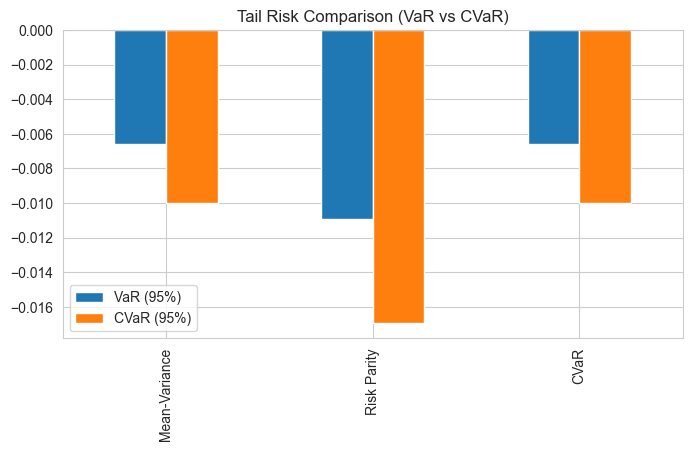

In [16]:
metrics_df[["VaR (95%)", "CVaR (95%)"]].plot(
    kind="bar",
    title="Tail Risk Comparison (VaR vs CVaR)"
)
plt.show()

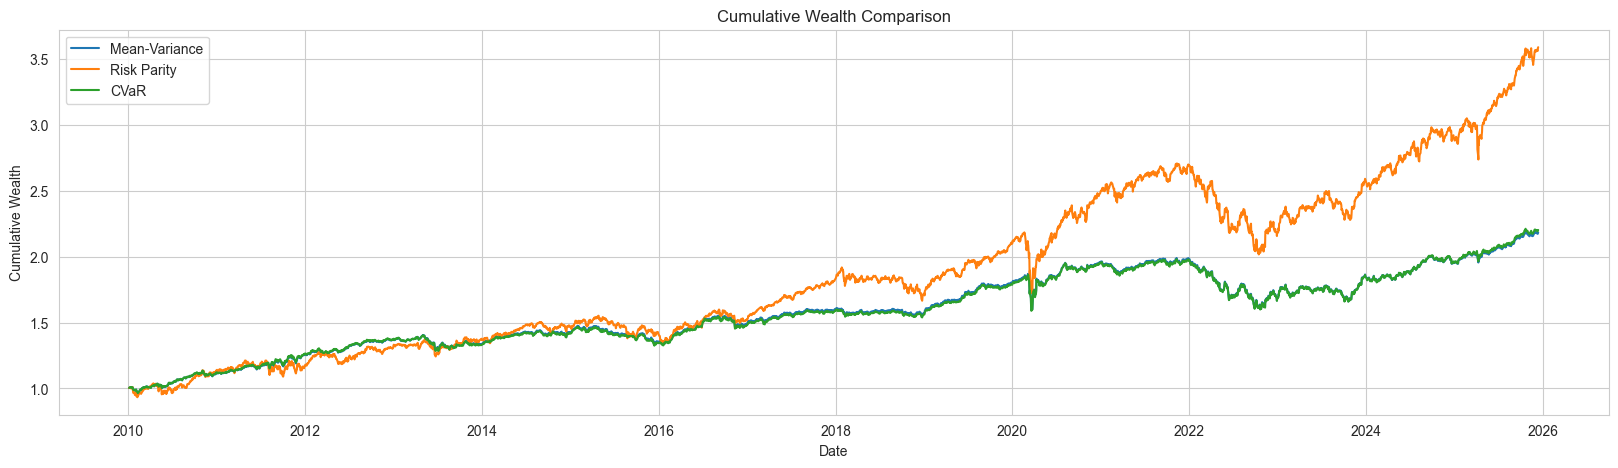

In [23]:
plt.figure(figsize=(20, 5))
wealth_curves = {
    name: pd.Series(
        np.exp(portfolio_returns(w_.values, returns_d.values).cumsum()),
        index=returns_d.index
    )
    for name, w_ in portfolios.items()
}
plt.plot(wealth_curves["Mean-Variance"], label="Mean-Variance")
plt.plot(wealth_curves["Risk Parity"], label="Risk Parity")
plt.plot(wealth_curves["CVaR"], label="CVaR")

plt.title("Cumulative Wealth Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Wealth")
plt.legend()
plt.show()

# 6. Weight Analysis & Structure

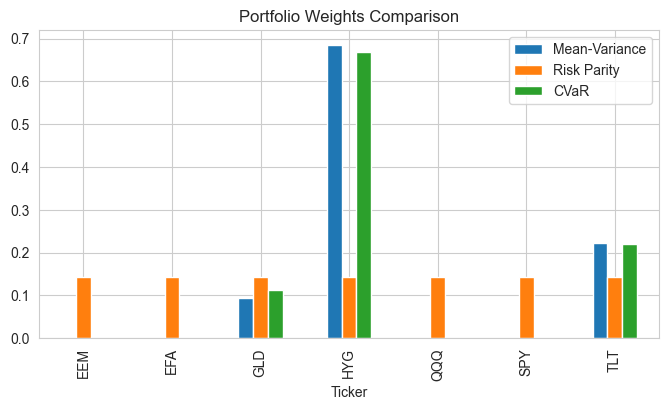

In [25]:
weights_df = pd.DataFrame({
    "Mean-Variance": w_mv,
    "Risk Parity": w_rp,
    "CVaR": w_cvar
})

weights_df.plot(kind="bar", title="Portfolio Weights Comparison")
plt.show()

The three portfolio construction methods exhibit similar long-term performance but fundamentally different risk behaviors.

Mean–Variance optimization generates highly concentrated allocations driven by noisy return estimates, leading to fragile portfolios exposed to large drawdowns when the dominant asset underperforms. Risk Parity achieves diversification in weights and variance, but suffers from elevated volatility and the worst tail risk, as it ignores loss asymmetry.

CVaR optimization clearly differentiates itself by reshaping the loss distribution rather than targeting variance or returns. The weight allocation avoids extreme concentration, cumulative wealth remains comparable, and tail-risk metrics (VaR and CVaR) show materially improved protection in extreme scenarios. CVaR trades return optimality for structural robustness, making it better suited for portfolios where downside control is the primary objective.

# Conclusion

CVaR optimization clearly improves downside risk control compared to mean–variance and risk parity, as confirmed by lower tail losses and more stable drawdowns. However, its effectiveness remains highly dependent on historical scenarios and the presence of past crisis periods, making it sensitive to regime changes and backward-looking by construction. CVaR does not forecast risk but reallocates exposure conditional on observed extremes. Overall, tail-risk–aware optimization offers a more realistic risk framework than variance minimization, while still requiring careful regime awareness and robustness checks.